In [2]:
import pandas as pd
import numpy as np
import sklearn 
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#!pip install stargazer
from stargazer.stargazer import Stargazer

In [3]:
cnty_data = pd.read_csv('u0_de.csv')
uas240 = pd.read_csv('uas240_may_14_2020.csv')
uas250 = pd.read_csv('uas250_july_22_2020.csv')
uas348 = pd.read_csv('uas348_july_21_2021.csv')

<ipython-input-3-bc416227c8a3>:2: DtypeWarning: Columns (17,18,19,20,21,22,24,25,377,378,379,465,741,747,753,918,930,942,991,1003,1015,1039,1051,1067,1079,1095,1107,1119) have mixed types. Specify dtype option on import or set low_memory=False.
  uas240 = pd.read_csv('uas240_may_14_2020.csv')
<ipython-input-3-bc416227c8a3>:3: DtypeWarning: Columns (24,25,266,272,278,1116,1190,1195,1233,1246,1300,1313,1330,1343,1364,1377) have mixed types. Specify dtype option on import or set low_memory=False.
  uas250 = pd.read_csv('uas250_july_22_2020.csv')
<ipython-input-3-bc416227c8a3>:4: DtypeWarning: Columns (24,25,789) have mixed types. Specify dtype option on import or set low_memory=False.
  uas348 = pd.read_csv('uas348_july_21_2021.csv')


In [4]:
cnty_data['CasesPerCapita'] = cnty_data['cases']/cnty_data['population']

#Select relevant columns for regression data
regr_data = cnty_data[['uasid', 'cnty_FIPS', 'CasesPerCapita', 'cl014_240', 'cl014_250', 'cl014_348', 
                       'immigrant_status', 'race']]

regr_data = regr_data.replace(['1 Yes, I now think post-secondary education is more valuable', \
                               '2 Yes, I now think post-secondary education is less valuable', \
                              '3 No', '4 Unsure'], [1, -1, 0, 0])
#Clean null values
regr_data = regr_data.replace(['.a', '.e'], [np.nan, np.nan])
regr_data = regr_data.dropna()

### Generate y (dependent) and X (independent) variables

In [5]:
#Build y variables
# regr_data['y_240_348'] = regr_data['cl014_348'] - regr_data['cl014_240'] #first VS last
# regr_data['y_250_348'] = regr_data['cl014_348'] - regr_data['cl014_250'] #max VS last

#One-hot-encode x-variables (race and immigrant status)
dummy_race = pd.get_dummies(regr_data.race, prefix = 'race')
regr_data = regr_data.join(dummy_race)
dummy_immgen = pd.get_dummies(regr_data.immigrant_status, prefix = 'immigrant_gen')
regr_data = regr_data.join(dummy_immgen)

### Generate control variables 

In [6]:
## Control variables: household income, education level and employment status.
## We assume that household income and education level stay consistent across all waves. Employment status may vary. 

#Merge UAS240 control variables
uas240 = uas240[['uasid', 'education','unemp_layoff', 'age', 'gender', 
                 'hisplatino', 'retired']]
uas240 = uas240.rename(columns = {'unemp_layoff':'240_unemp_layoff', 'hisplatino':'race_0 hisplatino'})

#Merge UAS250 and UAS348 control variables (employment only)
uas250 = uas250[['uasid', 'unemp_layoff']]
uas250 = uas250.rename(columns = {'unemp_layoff':'250_unemp_layoff'})
uas348 = uas348[['uasid', 'hhincome', 'unemp_layoff', 'hhmembernumber'] + [col for col in uas348.columns if 'hhmemberage' in col]]
uas348 = uas348.rename(columns = {'unemp_layoff':'348_unemp_layoff'})

#Merge and clean null values
for wave in [uas240, uas250, uas348]:
    regr_data = regr_data.merge(wave, on = 'uasid')

regr_data = regr_data.replace(['.a', '.e'], [np.nan, np.nan])
regr_data['haschild'] = regr_data[[col for col in regr_data.columns if 'hhmemberage' in col]].apply(lambda r: int(any(float(elem)<18 for elem in r)), axis=1)
for i in regr_data.index:
    haschild18 = False
    for col in [col for col in regr_data.columns if 'hhmemberage' in col]:
        age = float(regr_data.loc[i, col])
        if age >= 18 and age < 25:
            haschild18 = True
    regr_data.loc[i, 'haschild18'] = float(haschild18)

regr_data = regr_data.drop([col for col in regr_data.columns if 'hhmemberage' in col], axis=1, )
regr_data = regr_data.dropna()

#Clean datatypes for control variables
regr_data['hhincome'] = regr_data.hhincome.str[:2].astype('int32')
regr_data['education'] = regr_data.education.str[:2].astype('int32')
regr_data = regr_data.replace(['1 Yes', '0 No'], [1, 0])

## Unemployment indicator
regr_data['ue_ever'] = regr_data['240_unemp_layoff'] | regr_data['250_unemp_layoff'] | regr_data['348_unemp_layoff']

In [7]:
#Number of respondents in each category
display(regr_data.groupby('race').count()[['cl014_240', 'cl014_250', 'cl014_348']])
display(regr_data.groupby('immigrant_status').count()[['cl014_240', 'cl014_250', 'cl014_348']])

,cl014_240,cl014_250,cl014_348
race,,,
1 White Only,3204,3204,3204
2 Black Only,288,288,288
3 American Indian or Alaska Native Only,70,70,70
4 Asian Only,193,193,193
5 Hawaiian/Pacific Islander Only,22,22,22
6 Mixed,182,182,182


,cl014_240,cl014_250,cl014_348
immigrant_status,,,
0 Non-immigrant,2159,2159,2159
1 First generation immigrant,389,389,389
2 Second generation immigrant,525,525,525
3 Third generation immigrant,800,800,800
4 Unknown immigrant status,86,86,86


In [8]:
## Generate control dummies for educ and hhincome
thesis_data = regr_data[['cnty_FIPS', 'CasesPerCapita', 'uasid', 'cl014_240', 'cl014_250', 'cl014_348', 
        'immigrant_gen_0 Non-immigrant',
       'immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant',
        'hhincome', 'hhmembernumber', 'haschild', 'haschild18', 'education', 'immigrant_status', 'age', 'gender', 'race',''
        'race_0 hisplatino', 'race_1 White Only', 'race_2 Black Only',
       'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
       'race_5 Hawaiian/Pacific Islander Only', 'race_6 Mixed', 
        '240_unemp_layoff', '250_unemp_layoff', '348_unemp_layoff', 'ue_ever', 'retired']]

thesis_data['educ_c'] = pd.cut(thesis_data['education'], bins=[0, 4, 9, 12, 13, 14, 16], labels=['8', '12', '14', '16', '18', '20'])
thesis_data['educ_c'] = thesis_data.educ_c.astype('int32')
thesis_data['educ_less'] = pd.cut(thesis_data['education'], bins=[0, 8, 16], labels=[1, 0])
# thesis_data['educ_less'] = thesis_data.educ_less.astype('int32')

thesis_data['hhi_c'] = pd.qcut(regr_data['hhincome'], 5, labels = [0, 20, 40 , 60, 80])
thesis_data['hhi_c'] = thesis_data.hhi_c.astype('int32')
thesis_data['hhi_less'] = pd.cut(thesis_data['hhincome'], bins=[0, 6, 16], labels=[1, 0])
# thesis_data['hhi_less'] = thesis_data.hhi_less.astype('int32')
# https://uasdata.usc.edu/variable/UAS240/hhincome

thesis_data.replace(['1 Male', '0 Female'], [1, 0], inplace=True)
thesis_data['age'] = pd.to_numeric(thesis_data['age'])

In [9]:
thesis_data['haschild_total'] = (thesis_data['haschild'] + thesis_data['haschild18']) > 0
thesis_data['haschild_total'] = pd.to_numeric(thesis_data['haschild_total']).astype(int)

In [10]:
thesis_data.columns

Index(['cnty_FIPS', 'CasesPerCapita', 'uasid', 'cl014_240', 'cl014_250',
       'cl014_348', 'immigrant_gen_0 Non-immigrant',
       'immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 'hhincome',
       'hhmembernumber', 'haschild', 'haschild18', 'education',
       'immigrant_status', 'age', 'gender', 'race', 'race_0 hisplatino',
       'race_1 White Only', 'race_2 Black Only',
       'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
       'race_5 Hawaiian/Pacific Islander Only', 'race_6 Mixed',
       '240_unemp_layoff', '250_unemp_layoff', '348_unemp_layoff', 'ue_ever',
       'retired', 'educ_c', 'educ_less', 'hhi_c', 'hhi_less',
       'haschild_total'],
      dtype='object')

In [11]:
s_table = thesis_data.groupby('immigrant_status').std()[['cl014_240', 'cl014_250', 'cl014_348', 'educ_c', 'hhi_c', 'age', 'gender', 
                                                          'ue_ever', 'haschild', 'race_0 hisplatino',
                                                           'race_1 White Only', 'race_2 Black Only',
                                                           'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
                                                           'race_5 Hawaiian/Pacific Islander Only', 'race_6 Mixed']]
s_table = s_table.rename(columns = {'cl014_240': 'March 2020 view', 'cl014_250': 'July 2020 view', 'cl014_348':'July 2021 view',
                                   'educ_c':'education (years)', 'hhi_c':'household income (percentile)'})
s_table['Number of Observations'] = thesis_data.groupby('immigrant_status').count()['uasid']
s_table['Proportion in sample'] = thesis_data.groupby('immigrant_status').count()['uasid']/len(thesis_data)
s_table = s_table[['age', 'gender', 'education (years)', 'household income (percentile)', 
                   'March 2020 view', 'July 2020 view', 'July 2021 view','ue_ever', 'haschild',
                   'race_0 hisplatino',
                   'race_1 White Only', 'race_2 Black Only',
                   'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
                   'race_5 Hawaiian/Pacific Islander Only', 'race_6 Mixed',
                   'Proportion in sample', 'Number of Observations']]
s_table = s_table.round(4)
display(s_table.T)
# s_table.T.to_csv('summary_table_R.csv')

immigrant_status,0 Non-immigrant,1 First generation immigrant,2 Second generation immigrant,3 Third generation immigrant,4 Unknown immigrant status
age,14.7093,14.8819,18.1392,13.3289,15.5106
gender,0.4941,0.4976,0.4939,0.4991,0.4862
education (years),2.2175,2.4381,2.2054,2.1229,2.4088
household income (percentile),25.7352,26.7507,26.9605,25.7386,26.8267
March 2020 view,0.3990,0.4962,0.4486,0.3668,0.3235
July 2020 view,0.4981,0.5655,0.5693,0.4917,0.4058
July 2021 view,0.4773,0.5555,0.5211,0.4530,0.4800
ue_ever,0.2092,0.3041,0.2395,0.2305,0.1516
haschild,0.4532,0.4686,0.4557,0.3791,0.4567
race_0 hisplatino,0.1460,0.4656,0.4951,0.2615,0.2118


,March 2020,July 2020,July 2021
hhi_less,,,
1,0.093878,0.102041,0.148980
0,0.112424,0.115884,0.104353


Text(0, 0.5, 'Average change in views')

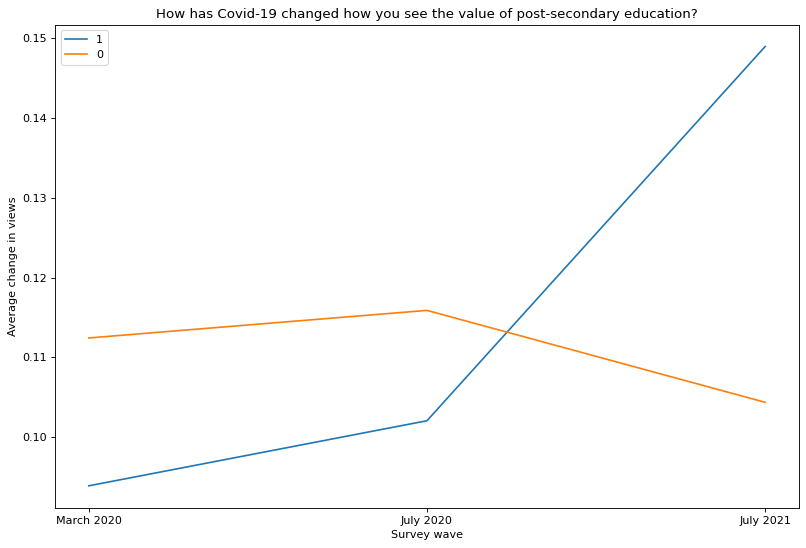

In [12]:
hhincome_t = thesis_data.groupby('hhi_less').mean()[['cl014_240', 'cl014_250', 'cl014_348']]
hhincome_t = hhincome_t.rename(columns = {'cl014_240':'March 2020', 'cl014_250':'July 2020', 'cl014_348':'July 2021'})
display(hhincome_t)

figure(figsize=(12, 8), dpi=80)
x = hhincome_t.columns
for q in hhincome_t.index:
    plt.plot(x, hhincome_t.loc[q, ], label = q)
plt.legend(loc = 'best')
plt.title('How has Covid-19 changed how you see the value of post-secondary education?')
plt.xlabel('Survey wave')
plt.ylabel('Average change in views')

,March 2020,July 2020,July 2021
educ_less,,,
1,0.146667,0.106667,0.080000
0,0.108690,0.114466,0.111053


Text(0, 0.5, 'Average change in views')

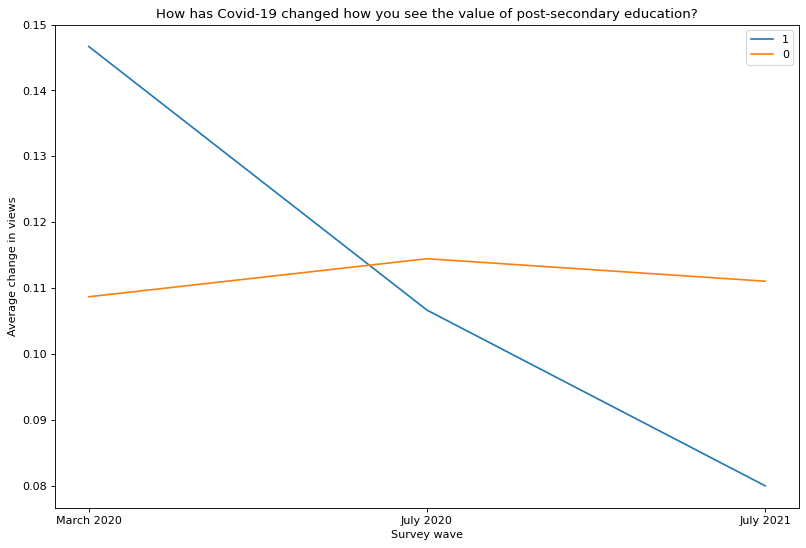

In [13]:
educ_t = thesis_data.groupby('educ_less').mean()[['cl014_240', 'cl014_250', 'cl014_348']]
educ_t = educ_t.rename(columns = {'cl014_240':'March 2020', 'cl014_250':'July 2020', 'cl014_348':'July 2021'})
display(educ_t)

figure(figsize=(12, 8), dpi=80)
x = educ_t.columns
for q in educ_t.index:
    plt.plot(x, educ_t.loc[q, ], label = q)
plt.legend(loc = 'best')
plt.title('How has Covid-19 changed how you see the value of post-secondary education?')
plt.xlabel('Survey wave')
plt.ylabel('Average change in views')

In [14]:
thesis_data = pd.get_dummies(thesis_data, columns = ['educ_c'])
thesis_data = pd.get_dummies(thesis_data, columns = ['hhi_c'])

thesis_data = pd.get_dummies(thesis_data, columns = ['hhi_less'])
thesis_data = pd.get_dummies(thesis_data, columns = ['educ_less'])

thesis_data['cases_quartiles'] = pd.qcut(thesis_data['CasesPerCapita'], 5, labels = ['case1', 'case2', 'case3', 'case4', 'case5'])
thesis_data = thesis_data.join(pd.get_dummies(thesis_data['cases_quartiles']))

thesis_data['age_quartiles'] = pd.cut(thesis_data['age'], [0, 30, 45, 60, 150], labels = ['age1', 'age2', 'age3', 'age4'])
thesis_data = thesis_data.join(pd.get_dummies(thesis_data['age_quartiles']))

#thesis_data.to_csv('rforest_data.csv')

In [15]:
# thesis_data = thesis_data.drop(['CasesPerCapita', 'cases_quartiles', 'race', 'education', 
# #                                 'hhincome', 
#                                 'immigrant_status', 'age', 'age_quartiles', 'gender'], axis = 1)

# imm_list = ['immigrant_gen_0 Non-immigrant',
#             'immigrant_gen_1 First generation immigrant', 
#             'immigrant_gen_2 Second generation immigrant',
#             'immigrant_gen_3 Third generation immigrant']
# race_list = ['race_1 White Only', 'race_2 Black Only',
#        'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
#        'race_5 Hawaiian/Pacific Islander Only', 'race_6 Mixed']

# for i in range(4):
#     for r in range(6):
#         thesis_data['imm{}*race{}'.format(i, r)] = thesis_data[imm_list[i]] * thesis_data[race_list[r]]

#thesis_data['imm_1 * hhi_c_0th'] = thesis_data['immigrant_gen_1 First generation immigrant'] * thesis_data['hhi_c_0']
pd.set_option('display.max_columns', None)
# thesis_data

In [23]:
thesis_data.to_csv('uas_data_R2.csv')